# Partial Path Distribution
How does the probability of partial paths(across different layers), $p(L1, L_2, L_3, L_4)$ look like? In this notebook we will try to visualize a more simplified form with only two distributions, $\sum_{i=1}^3 L_i$ and $L_4$. This allows us to plot a 2D heatmap of the probability distribution rather some slices of some 4D plot.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tfo_sensitivity.data import load_raw
import seaborn as sns
from pathlib import Path

# Plot Setup
# plt.style.use('seaborn')
plt.rcParams["figure.dpi"] = 700  # Paper-ready plots
# Load Sim Data (Using functions)
# maternal_wall_thickness, uterus_thickness, wave_int = 6, 5, 2
# raw_sim_data_path = load_raw(maternal_wall_thickness, uterus_thickness, wave_int)

# Load sim data directly
raw_sim_data_path = Path(r'/home/rraiyan/simulations/tfo_sim/data/dan_iccps_pencil/fa_1_wv_2_sa_0.1_ns_1_ms_12_ut_5.pkl')
sim_data = pd.read_pickle(raw_sim_data_path)

# Create SDD column!
sim_data['SDD'] = sim_data['X'] - sim_data['Y'] # The way I have detectors defined, only X chhanges with SDD, Y stays the same

all_sdd = sim_data['SDD'].unique()
all_sdd.sort()
current_sdd = all_sdd[0]    

sim_data = sim_data[sim_data['SDD'] == current_sdd]
sim_data["sum_L"] = sim_data["L1 ppath"] + sim_data["L2 ppath"] + sim_data["L3 ppath"]
sim_data.describe()

,X,Y,Z,L1 ppath,L2 ppath,L3 ppath,L4 ppath,SDD,sum_L
count,20513914.0,20513914.0,20513914.0,2.051391e+07,2.051391e+07,2.051391e+07,2.051391e+07,20513914.0,2.051391e+07
mean,115.0,105.0,67.0,1.079955e+02,1.397885e+01,1.952678e+00,2.247829e+01,10.0,1.239270e+02
std,0.0,0.0,0.0,9.884563e+01,5.198662e+01,9.912183e+00,1.757480e+02,0.0,1.452278e+02
min,115.0,105.0,67.0,9.457766e+00,0.000000e+00,0.000000e+00,0.000000e+00,10.0,9.457766e+00
25%,115.0,105.0,67.0,4.479181e+01,0.000000e+00,0.000000e+00,0.000000e+00,10.0,4.479211e+01
50%,115.0,105.0,67.0,7.564695e+01,0.000000e+00,0.000000e+00,0.000000e+00,10.0,7.582058e+01
75%,115.0,105.0,67.0,1.354832e+02,0.000000e+00,0.000000e+00,0.000000e+00,10.0,1.419041e+02
max,115.0,105.0,67.0,2.286429e+03,1.899933e+03,5.133493e+02,1.369515e+04,10.0,3.940534e+03


In [2]:
all_sdd

array([10., 15., 19., 24., 28., 33., 37., 41., 46., 50., 55., 59., 64.,
       68., 72., 77., 81., 86., 90., 94.])

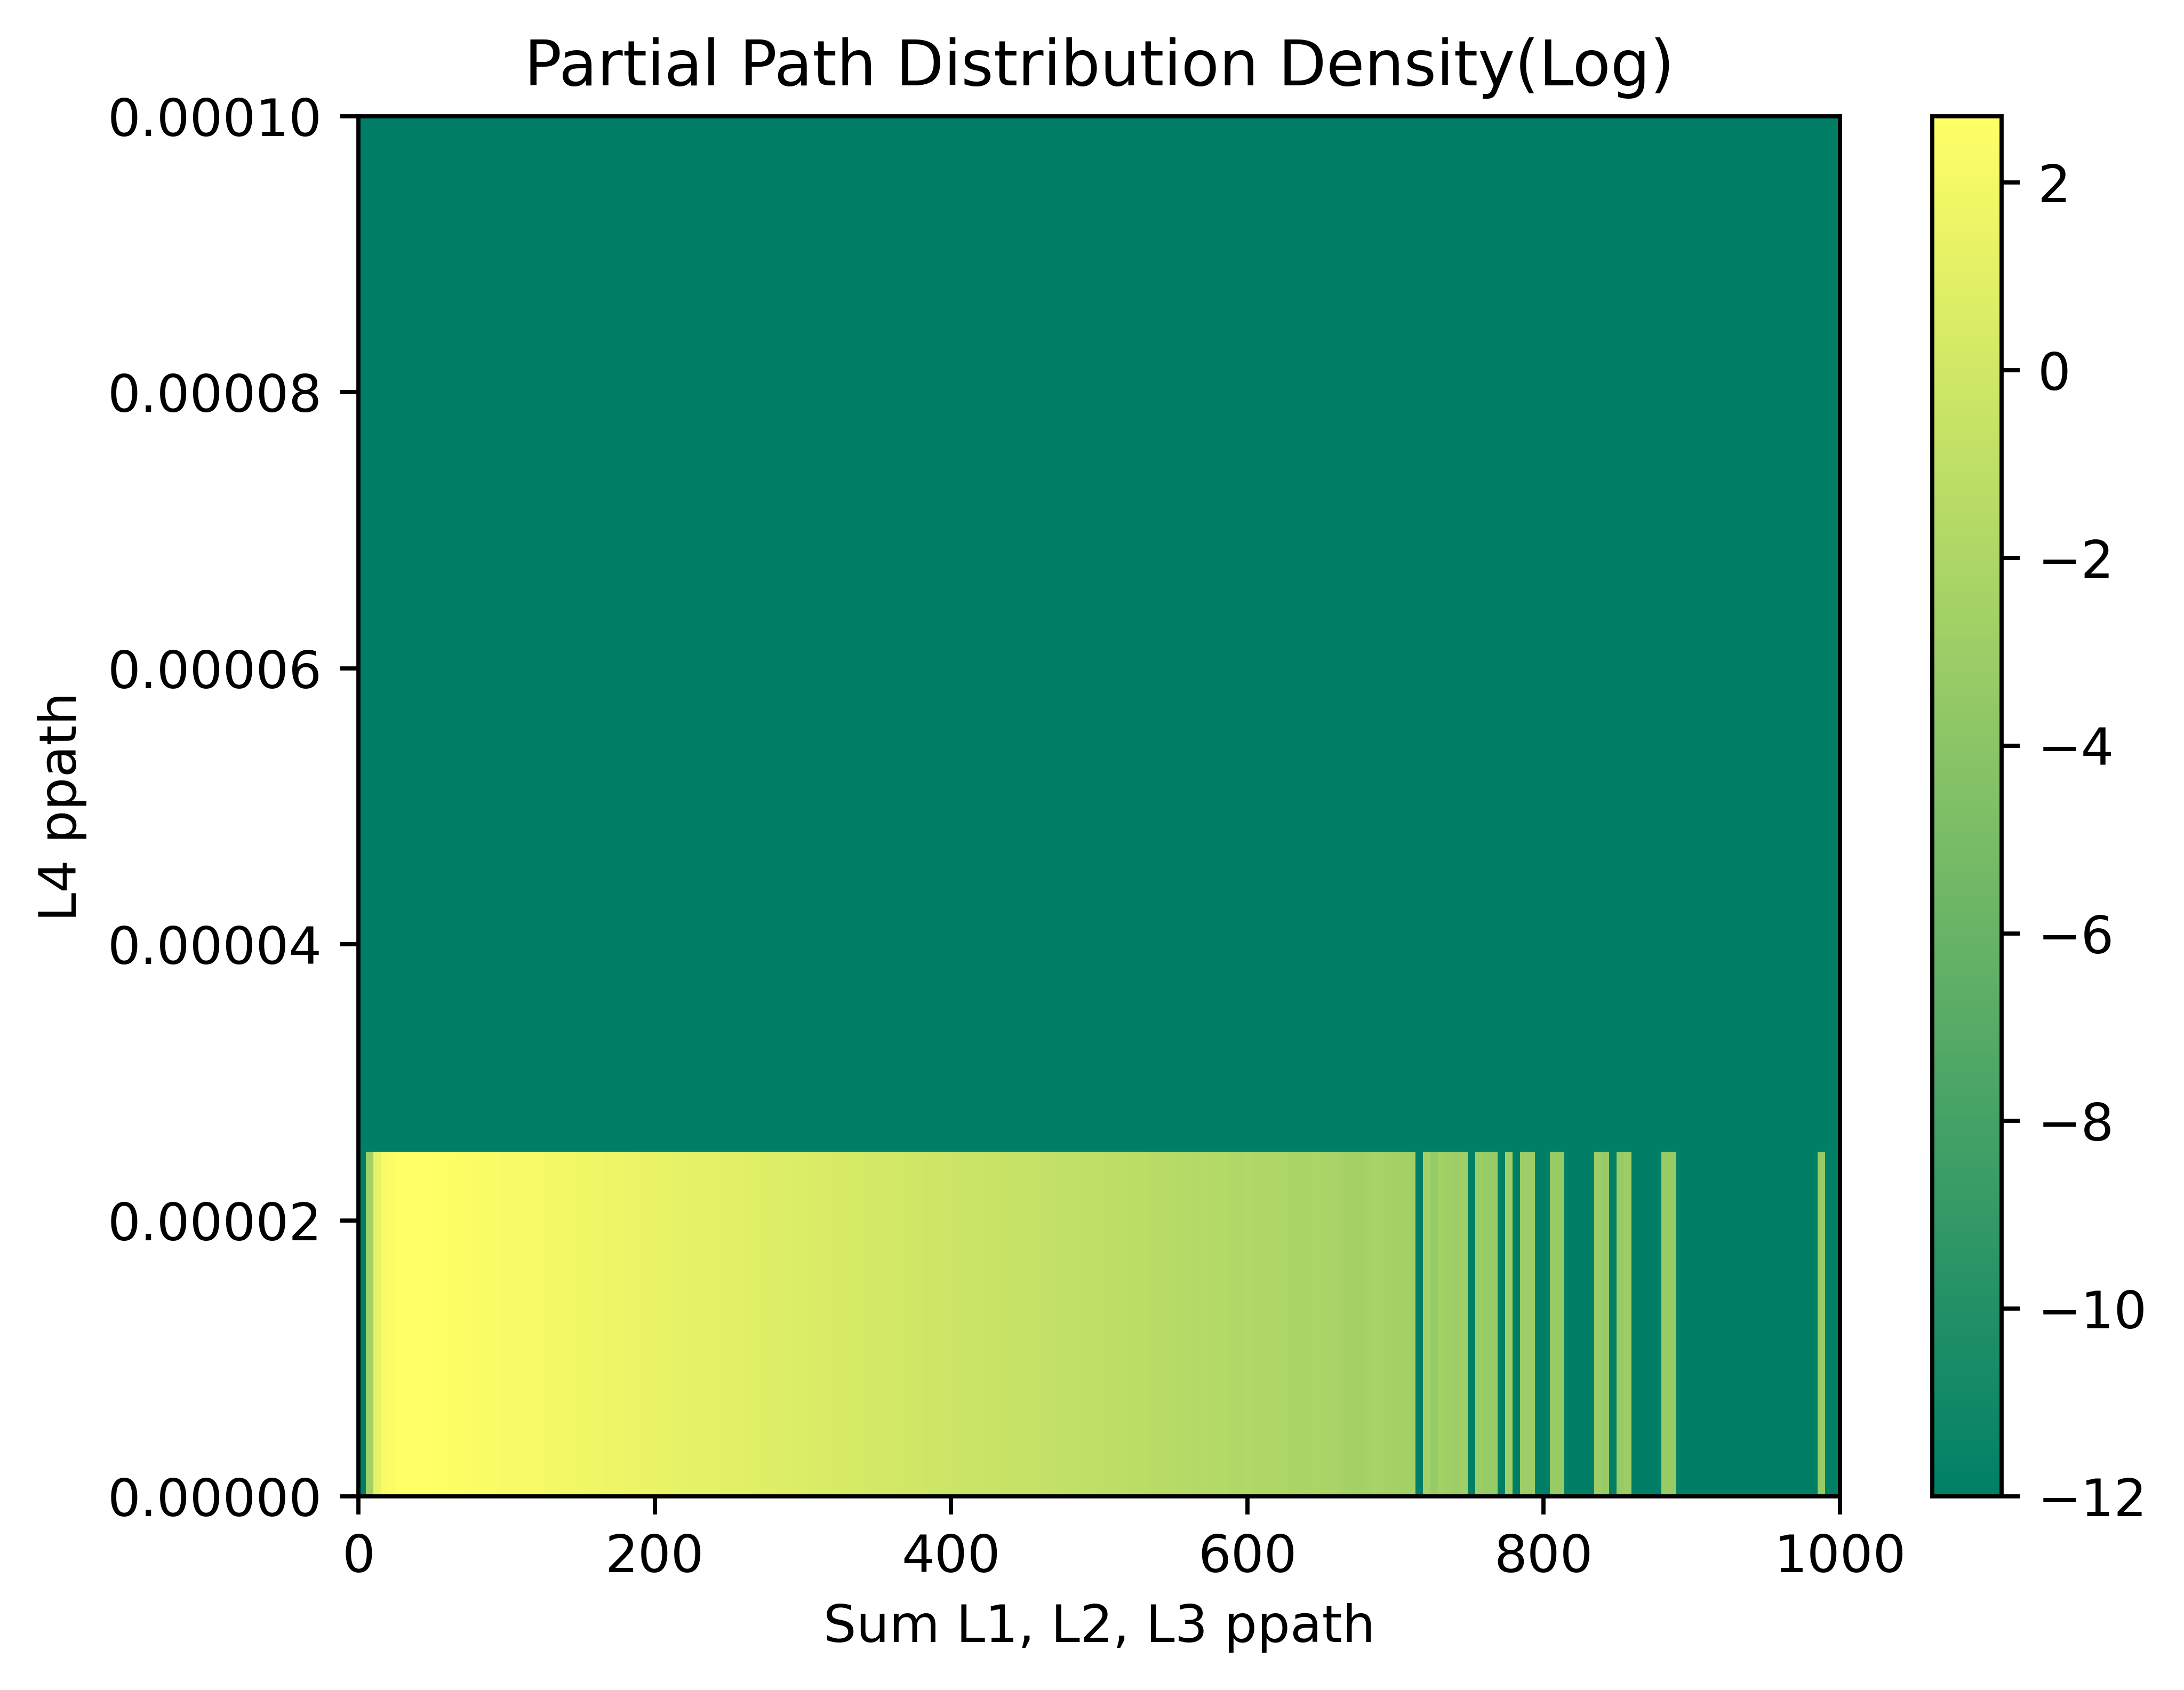

In [8]:
# Create a 2D histogram of the sum_L4 and L4 ppath columns
# sim_data = sim_data[sim_data["L4 ppath"] > 0.001]


# bin_edges_x = np.linspace(0, 2000, 200)
# bin_edges_y = np.linspace(0, 3000, 200)

bin_edges_x = np.linspace(0, 1000, 200)
bin_edges_y = np.linspace(0, 0.0001, 5)
hist_2d, x_edges, y_edges = np.histogram2d(sim_data["L1 ppath"], sim_data["L2 ppath"], bins=[bin_edges_x, bin_edges_y],
                                           density=True)
# hist_2d, x_edges, y_edges = np.histogram2d(sim_data["sum_L"], sim_data["L4 ppath"], bins=400)

# Plot the 2D histogram
fig, ax = plt.subplots()
EPSILON = 1e-12
hist_2d[hist_2d == 0.0] = EPSILON
plt.imshow(np.log10(hist_2d.T), interpolation='nearest', origin='lower',
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto', cmap='summer')

# plt.imshow(hist_2d.T, interpolation='nearest', origin='lower',
#            extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto', cmap='summer')
plt.colorbar()
plt.title("Partial Path Distribution Density(Log)")
plt.xlabel('Sum L1, L2, L3 ppath')
plt.ylabel("L4 ppath")
plt.show()


# Independence Test
Are the probability distributions for each of the pathlengths independent?

The fastest way is to check their Mutual Information. If its 0 -> independent

In [4]:
from sklearn.metrics import mutual_info_score
mi_matrix = np.zeros((4, 4))
for i in range(4):
    for j in range(i, 4):
        mi_matrix[i, j] = mutual_info_score(sim_data[f"L{i + 1} ppath"].round(), sim_data[f"L{j + 1} ppath"].round())

print(mi_matrix)

[[5.50650975 0.27479703 0.13591198 0.16129905]
 [0.         1.41070537 0.28523584 0.28913482]
 [0.         0.         0.6425751  0.32872029]
 [0.         0.         0.         0.81423318]]


In [16]:
import scipy
r_matrix = np.zeros((4, 4))
for i in range(4):
    for j in range(i, 4):
        r_matrix[i, j], _ = scipy.stats.spearmanr(sim_data[f"L{i + 1} ppath"].round().to_numpy().reshape(-1, 1), sim_data[f"L{j + 1} ppath"].round().to_numpy().reshape(-1, 1))

print(r_matrix)

[[1.         0.58313973 0.41832792 0.41498614]
 [0.         1.         0.72487293 0.71891059]
 [0.         0.         1.         0.99141287]
 [0.         0.         0.         1.        ]]


In [5]:
from scipy.stats import skew, kurtosis

print("Skewness")
print(skew(sim_data["L1 ppath"]))
print(skew(sim_data["L2 ppath"]))
print(skew(sim_data["L3 ppath"]))
print(skew(sim_data["L4 ppath"]))
print("Mean")
print(sim_data["L1 ppath"].mean())
print(sim_data["L2 ppath"].mean())
print(sim_data["L3 ppath"].mean())
print(sim_data["L4 ppath"].mean())
print("Std")
print(sim_data["L1 ppath"].std())
print(sim_data["L2 ppath"].std())
print(sim_data["L3 ppath"].std())
print(sim_data["L4 ppath"].std())
print("Kurtosis")
print(kurtosis(sim_data["L1 ppath"]))
print(kurtosis(sim_data["L2 ppath"]))
print(kurtosis(sim_data["L3 ppath"]))
print(kurtosis(sim_data["L4 ppath"]))


Skewness
2.7720171035428507
6.5503716993912935
8.792337281254047
15.432552496034447
Mean


107.99545403609174
13.978854919540332
1.952677838310998
22.47829406621019
Std
98.84563201486269
51.986622462861746
9.912182563185924
175.74796965136875
Kurtosis
12.786933396102961
63.10215430211301
112.34940358763048
344.197796124073
